# MLB Baseball Predictions
> Introducing the baseball betting project.

- toc: false
- badges: true
- comments: true
- categories: [baseball, benchmark, web_scraping, brier, accuracy, calibration]
- image: images/chart-preview.png

Baseball isn’t associated with good memories for me. I wasn’t very good at it, always hitting foul balls in little league. My parents eventually figured out I needed glasses, but not before I developed a mild disdain for the sport. So it’s with great surprise that I find myself spending so much time thinking about it. Even more so when I make a bet and start cheering for a team. It’s amazing what having some skin in the game will do for your interest level.

This is the first in a blog series, written in jupyter notebooks, which will show you how to build a program that predicts the outcome of MLB games. We'll be using our web scraping and machine learning skills to build a model that outperforms the casino's sports books.

> Important: Web scraping is dependant on other people's web pages. If they change their site, this blog's code will break. Don't expect the code presented here to work forever.

# Benchmarking the Sportsbooks
First thing to do is figure out how we’re going to know if we’re doing well. The most intuitive performance benchmark I found was the sportsbooks themselves. If I can make better predictions than the sportsbooks, then I should be doing well.

## Downloading Sportsbook Data
We need to start by putting together a database of historic odds and outcomes for MLB games. First step is to get a list of days when games were played. We can get those from [baseball-reference.com](http://baseball-refence.com).

In [7]:
import requests
import re
import datetime as dt
url = 'https://www.baseball-reference.com/leagues/MLB/2019-schedule.shtml'
resp = requests.get(url)
# All the H3 tags contain day names
days = re.findall("<h3>(.*2019)</h3>", resp.text)
dates = [dt.datetime.strptime(d,"%A, %B %d, %Y") for d in days]
print("Number of days MLB was played in 2019:", len(dates))

Number of days MLB was played in 2019: 210


We need the correct days because we'll be pulling the odds data from [covers.com](http://covers.com) by day. Covers aggregates the published odds from several sources and then publishes a consensus moneyline. We'll grab that, along with the score of the game. Here's how we pull and parse that data.

In [8]:
from bs4 import BeautifulSoup as bs
game_data = []
for d in dates:
    # get the web page with game data on it
    game_day = d.strftime('%Y-%m-%d')
    url = f'https://www.covers.com/Sports/MLB/Matchups?selectedDate={game_day}'
    resp = requests.get(url)

    # parse the games
    scraped_games = bs(resp.text).findAll('div',{'class':'cmg_matchup_game_box'})
    for g in scraped_games:
        game = {}
        game['home_moneyline'] = g['data-game-odd']
        game['date'] = g['data-game-date']
        try:
            game['home_score'] =g.find('div',{'class':'cmg_matchup_list_score_home'}).text.strip()
            game['away_score'] =g.find('div',{'class':'cmg_matchup_list_score_away'}).text.strip()
        except:
            game['home_score'] =''
            game['away_score'] =''

        game_data.append(game)
        if len(game_data) % 500==0:
            #show progress
            print(dt.datetime.now(), game_day, len(game_data))
print("Done! Games downloaded:", len(game_data))

2020-09-20 09:18:42.373122 2019-05-02 500
2020-09-20 09:19:31.667990 2019-06-08 1000
2020-09-20 09:20:01.571727 2019-07-18 1500
2020-09-20 09:20:31.480630 2019-08-24 2000
2020-09-20 09:21:05.637996 2019-10-03 2500
Done! Games downloaded: 2533


Here's what that data looks like. You can see the moneyline was negative, meaning that the home team was favored. But the home team lost, so the prediction from the casinos was inaccurate in this case.

In [9]:
game_data[0]

{'home_moneyline': '-155',
 'date': '2019-03-20 05:35:00',
 'home_score': '7',
 'away_score': '9'}

## Sportsbook Accuracy
Let's see how the sportsbook did in all the games we just downloaded.

In [10]:
from sklearn.metrics import accuracy_score

# the actual outcome of the game, true if the the home team won
outcomes = []
# predictions derived from moneyline odds. True if the home team was the favorite
predictions = []
# probability the home team will win, derived from moneyline odds
# derived from formulas at https://www.bettingexpert.com/academy/advanced-betting-theory/odds-conversion-to-percentage
probabilities = []

for d in game_data:
    try:
        moneyline = int(d['home_moneyline'])
        home_score = int(d['home_score'])
        away_score = int(d['away_score'])
    except:
        #incomplete data
        continue
    if moneyline==100:
        # it's rare to have a tossup since covers is averaging the odds from several sports books
        # but we'll exclude them from our calculations
        continue

    # convert moneyline odds ot their implied probabilities
    if moneyline<0:
        probabilities.append(-moneyline/(-moneyline + 100))
    elif moneyline>100:
        probabilities.append(100/(moneyline + 100))

    outcomes.append(home_score>away_score)
    predictions.append(moneyline<0)

print("Sportsbook accuracy (excluding tossups): {0:.2f}%".format(100*accuracy_score(outcomes,predictions)))

Sportsbook accuracy (excluding tossups): 60.06%


That's it, right? We need a model that is better than 60% accurate.

If you plan to use this data for betting, you should have more than a win/loss prediction. To really make money, we would like to know if we think the odds of a team winning are better or worse that what the sportsbook thinks they are. Then we'd be able to use some sort of [expected value calculation](https://en.wikipedia.org/wiki/Expected_value) to determine if the bet is profitable.

## Sportsbook Calibration
We really want to know if we can build a model that is better [calibrated](https://en.wikipedia.org/wiki/Calibration_(statistics)) than the casino's sportsbooks. Knowing our calibration will help us with bet sizing, as well as more sophisticated betting algorithms. Here's a graphical view of the calibration of the casino sports book data.

SportsBook	Accuracy:0.6006	 Brier Loss: 0.2358


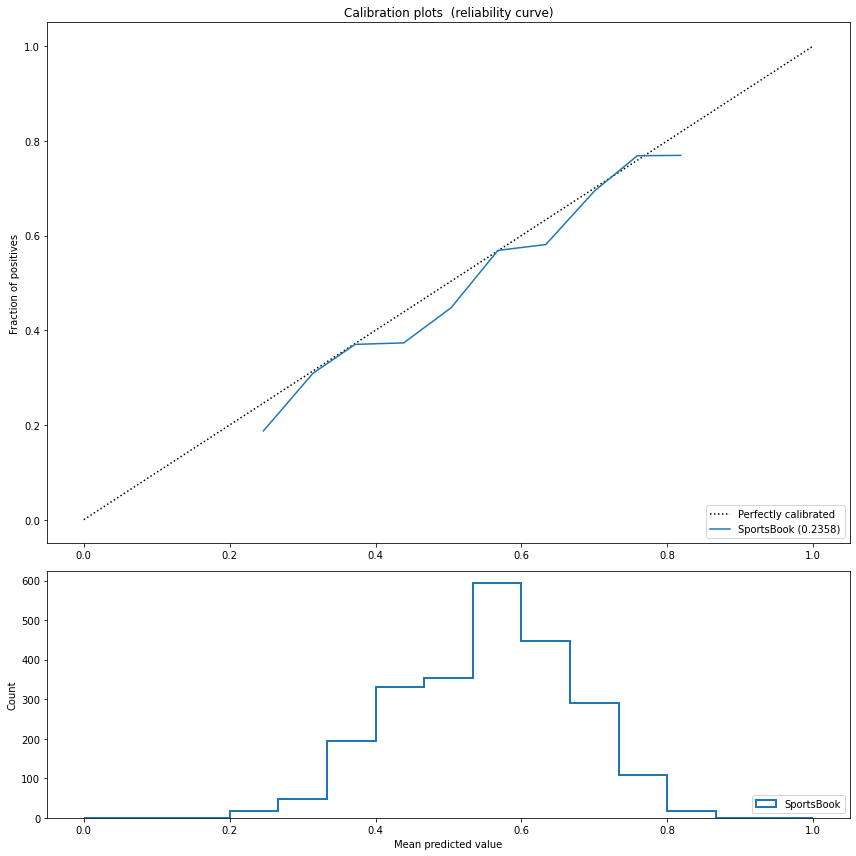

In [11]:
#collapse-hide
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, brier_score_loss
import matplotlib.pyplot as plt

def cal_curve(data, bins):
    # adapted from:
    #https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html
    fig = plt.figure(1, figsize=(12, 12))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    for y_test, y_pred, y_proba, name in data:
        brier = brier_score_loss(y_test, y_proba)
        print("{}\tAccuracy:{:.4f}\t Brier Loss: {:.4f}".format(
            name, accuracy_score(y_test, y_pred), brier))
        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, y_proba, n_bins=bins)
        ax1.plot(mean_predicted_value, fraction_of_positives,
                 label="%s (%1.4f)" % (name, brier))
        ax2.hist(y_proba, range=(0, 1), bins=bins, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

data = [(outcomes, predictions, probabilities, 'SportsBook')]
cal_curve(data, 15)

The graph above tells us several things about the calibration of the casino's predictions. The reliability curve clearly shows that the casino is highly calibrated. Interestingly, it looks like the blue line is shifted down slightly from the "perfectly calibrated" line. It would be a better fit if it was 0.05 higher. This may account for the house advantage.

The histogram below shows what portion of the games fall into each bin. We see a slight predicted advantage to the home team, with more than 50% of the observations above the 50% mark. Otherwise it looks pretty normally distributed.

Above, I said the reliability curve looks highly calibrated. If we are to judge our own efforts against the sportsbook, we can't just be eyeballing this graph all the time. A metric would be nice. One metric that is suited for calibration measurement is the [Brier Score](https://en.wikipedia.org/wiki/Brier_score), which I'll be using to measure the model effectiveness going forward. Getting a model that scores less than 0.2358 is the target.

# Next Up
Next, we'll start building out our historic data and training the model using XGBoost and LightGBM.
